<center><h1>Localization</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://github.com/arthurdouillard/deepcourse/issues).

In [ ]:
!nvidia-smi

Sat May 21 07:16:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/loc/imagenet.json

--2022-05-21 07:16:34--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/loc/imagenet.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139568 (136K) [text/plain]
Saving to: ‘imagenet.json’

imagenet.json       100%[===================>] 136.30K  --.-KB/s    in 0.002s  

2022-05-21 07:16:34 (62.9 MB/s) - ‘imagenet.json’ saved [139568/139568]



In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
import torchvision
from PIL import Image
from nltk.corpus import wordnet as wn

In this colab, we are going to **localize** objects in an image, without even training a model.

Or to be more correct, with only taking a model pretrained on classification.

Let's load our resnet pretrained on ImageNet:

In [ ]:
net = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

We need to modify its forward function. Ideally we should have download the code and modify it. But on colab, it may be a bit unpracticable, so we are going to monkey-patch the forward function.

We strip the last global average pooling (`self.avgpool`) and the classifier (`self.fc`) and we add a new layer that we call `self.conv1x1`:

In [ ]:
net.forward

In [ ]:
def forward(self, x):
  x = self.conv1(x)
  x = self.bn1(x)
  x = self.relu(x)
  x = self.maxpool(x)

  x = self.layer1(x)
  x = self.layer2(x)
  x = self.layer3(x)
  x = self.layer4(x)

  # We remove those two layers...
  # x = self.avgpool(x)
  # x = self.fc(x)

  # ... and we add this layer:
  x = self.conv1x1(x)

  return x


net.forward = forward.__get__(
    net,
    torchvision.models.ResNet
);  # monkey-patching

In [ ]:
net

We are going to exploit an important fact to do our localization for free.

Convolution with 1x1 kernel, also called **pointwise convolutions**, are actually a fully-connected layer applied independently on every pixels.

We need the spatial dimension, that we loose with global pooling and fully-connected, to do localization. Therefore we are going to convert a fully-connected layer in a 1x1 convolution.

Inspect the weights and bias shapes of both layers, and try to find a way to transfer the parameters learned by one to the other:

In [ ]:
print("fc weight and bias:", net.fc.weight.data.shape, net.fc.bias.data.shape)

conv1x1 = nn.Conv2d(2048, 1000, kernel_size=1)
conv1x1.weight.data = net.fc.weight.data[..., None, None]
conv1x1.bias.data = net.fc.bias.data

print("conv1x1 weight and bias:", conv1x1.weight.data.shape, conv1x1.bias.data.shape)

fc weight and bias: torch.Size([1000, 2048]) torch.Size([1000])
conv1x1 weight and bias: torch.Size([1000, 2048, 1, 1]) torch.Size([1000])


In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/loc/conv.py
%pycat conv.py

--2022-05-21 07:26:48--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/loc/conv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95 [text/plain]
Saving to: ‘conv.py’

conv.py             100%[===================>]      95  --.-KB/s    in 0s      

2022-05-21 07:26:49 (5.15 MB/s) - ‘conv.py’ saved [95/95]



And don't forget to provide this new conv to the network:

In [ ]:
net.conv1x1 = conv1x1

Just to be sure, check the output dimension:

In [ ]:
net(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 1000, 7, 7])

Now we want to localize a class in particular. Let's say the class "dog". You can take an other class if you want, I only use this one because it is the most frequent class of ImageNet.

Among ImageNet's 1000 classes, there are hundred of dog species.

Luckily, ImageNet's classes are based on the hierarchy of **wordnet**. Therefore we can find classes belonging to "dog".

First, we load wordnet:

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Then, we load the classes of ImageNet and their id (**synset**) in the wordnet hierarchy

In [ ]:
with open("imagenet.json") as f:
  imagenet_labels = json.load(f)

In [ ]:
!head imagenet.json

{
  "0": {
    "id": "01440764-n",
    "label": "tench, Tinca tinca",
    "uri": "http://wordnet-rdf.princeton.edu/wn30/01440764-n"
  },
  "1": {
    "id": "01443537-n",
    "label": "goldfish, Carassius auratus",
    "uri": "http://wordnet-rdf.princeton.edu/wn30/01443537-n"


We aggregate all dog classes:

In [ ]:
class_to_localize = "dog"

parent_name = wn.synsets(class_to_localize)[0]._name
print(f"Parent is <{parent_name}>")

indexes = set()
names = set()

for index, metadata in imagenet_labels.items():
  base_synset = wn.synset_from_pos_and_offset("n", int(metadata["id"].split('-')[0]))

  synset = base_synset
  while synset._name != parent_name:
    parents = synset.hypernyms()
    if len(parents) == 0:  # no more parents, we are at the root
      break

    synset = parents[0]

  if synset._name == parent_name:
    indexes.add(int(index))
    names.add(base_synset._name)

indexes = torch.tensor(list(indexes))
print(f"There are {len(indexes)} classes")
list(names)[:10]

Parent is <dog.n.01>
There are 118 classes


['bedlington_terrier.n.01',
 'beagle.n.01',
 'staffordshire_bullterrier.n.01',
 'brabancon_griffon.n.01',
 'walker_hound.n.01',
 'black-and-tan_coonhound.n.01',
 'chesapeake_bay_retriever.n.01',
 'shih-tzu.n.01',
 'boston_bull.n.01',
 'miniature_pinscher.n.01']

Let's try our model on an image with two dogs (but you can use any image you want):

In [ ]:
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/loc/2dogs.jpg

--2022-05-21 07:35:33--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/loc/2dogs.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288984 (282K) [image/jpeg]
Saving to: ‘2dogs.jpg’

2dogs.jpg           100%[===================>] 282.21K  --.-KB/s    in 0.003s  

2022-05-21 07:35:35 (102 MB/s) - ‘2dogs.jpg’ saved [288984/288984]



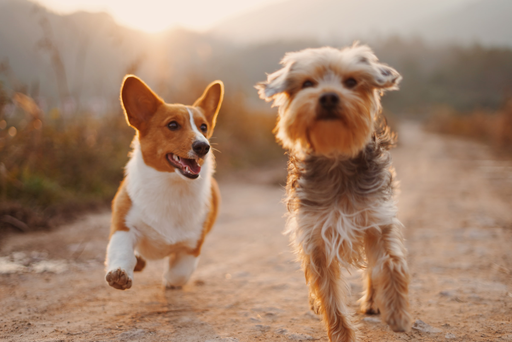

In [ ]:
image = Image.open("2dogs.jpg")
image.thumbnail((512, 512), Image.ANTIALIAS)
image

We still need to preprocess our imagenet in the same way the model was trained:

In [ ]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

Now code a method to get the *attention* of the model which will be our localization.

Here are the steps:

1. resize image to the asked dimensions
2. preprocess the image
3. extract the spatial logits
4. use softmax alongside the correct dimension
5. only keep the channels in `indexes` that we computed from wordnet and sum them


*Pro-tip*: to avoid storing intermediary activations that are useful only when doing backward, use the context manager `torch.no_grad()`:

```python
with torch.no_grad():
  y = net(x)
```

In [ ]:
def generate_attention(path, size=(224, 224)):
  image = Image.open(path)
  image.thumbnail(size, Image.ANTIALIAS)

  # TODO
  tensor = transform(image)[None]

  with torch.no_grad():
    logits = net(tensor)[0] # we choose depth, height, width

    probs = torch.softmax(logits, dim=0)
    # print(torch.sum(probs[:,0,0]))
    attention_map = probs[indexes].sum(dim=0)



  return image, attention_map

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/loc/attn.py
%pycat attn.py

--2022-05-21 07:36:28--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/loc/attn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316 [text/plain]
Saving to: ‘attn.py’

attn.py             100%[===================>]     316  --.-KB/s    in 0s      

2022-05-21 07:36:29 (19.5 MB/s) - ‘attn.py’ saved [316/316]



Let's try it!

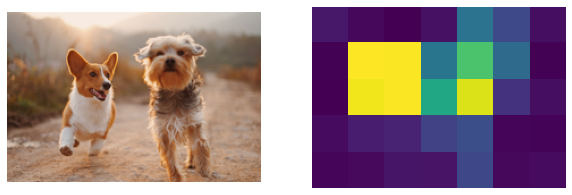

In [ ]:
image, attn = generate_attention("2dogs.jpg", (224, 224))

plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 2, 1)
ax.axis("off")
plt.imshow(image)

ax = plt.subplot(1, 2, 2)
ax.axis("off")
plt.imshow(attn)

Hum... Not that great right? I mean we knew it won't be very precise, but this is super bad.

But what if the resolution was larger?...

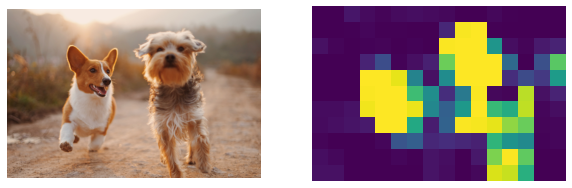

In [ ]:
image, attn = generate_attention("2dogs.jpg", (512, 512))

plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 2, 1)
ax.axis("off")
plt.imshow(image)

ax = plt.subplot(1, 2, 2)
ax.axis("off")
plt.imshow(attn)

larger?

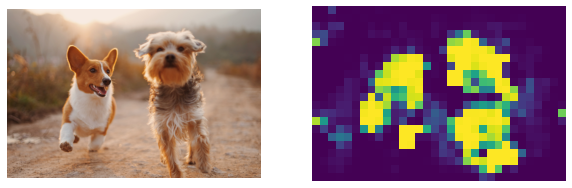

In [ ]:
image, attn = generate_attention("2dogs.jpg", (1024, 1024))

plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 2, 1)
ax.axis("off")
plt.imshow(image)

ax = plt.subplot(1, 2, 2)
ax.axis("off")
plt.imshow(attn)

larger?!

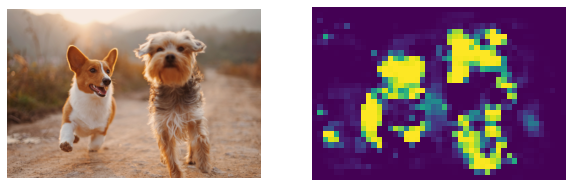

In [ ]:
image, attn = generate_attention("2dogs.jpg", (1500, 1500))

plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 2, 1)
ax.axis("off")
plt.imshow(image)

ax = plt.subplot(1, 2, 2)
ax.axis("off")
plt.imshow(attn)

You should see more precisely the shapes of the dogs as the resolution (and computational cost) increases.

But as the resolution is larger, there are also more artefacts where the model thinks it has found a dog somewhere in the background.

A solution, which is essential to even modern network in segmentation, is to exploit **multiple scales**.

Compute the attention with the same image resized at different dimensions, and combine all those attentions together. There can be different aggregation method although I recommend a [geometric mean](https://en.wikipedia.org/wiki/Geometric_mean).

In [ ]:
F.interpolate(attn[None, None], (32, 47))[0, 0].shape

torch.Size([32, 47])

torch.Size([32, 47])


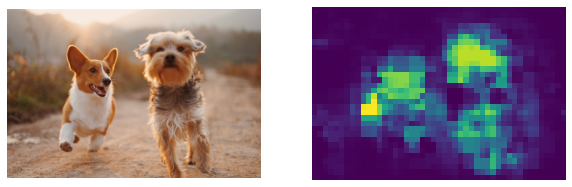

In [ ]:
resized_attn = torch.ones(32, 47)

sizes = (112, 224, 512, 1024, 1500)
for size in sizes:
  image, attn = generate_attention("2dogs.jpg", (size, size))
  resized_attn *= F.interpolate(attn[None, None], (32, 47))[0, 0] # for selecting 32, 47 from 1,1,32,47

print(resized_attn.shape)
final_attn = torch.pow(resized_attn, 1/len(sizes))

plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 2, 1)
ax.axis("off")
plt.imshow(image)

ax = plt.subplot(1, 2, 2)
ax.axis("off")
plt.imshow(final_attn)

torch.Size([32, 47])


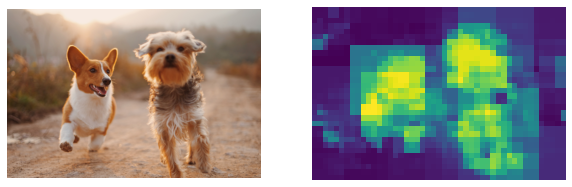

In [ ]:
resized_attn = torch.ones(32, 47)

sizes = (112, 224, 512, 1024, 1500)
for size in sizes:
  image, attn = generate_attention("2dogs.jpg", (size, size))
  resized_attn += F.interpolate(attn[None, None], (32, 47))[0, 0] # for selecting 32, 47 from 1,1,32,47

print(resized_attn.shape)
final_attn = torch.pow(resized_attn, 1/len(sizes))

plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 2, 1)
ax.axis("off")
plt.imshow(image)

ax = plt.subplot(1, 2, 2)
ax.axis("off")
plt.imshow(final_attn)

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/loc/geom.py
%pycat geom.py

--2022-05-21 08:08:07--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/loc/geom.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 411 [text/plain]
Saving to: ‘geom.py’

geom.py             100%[===================>]     411  --.-KB/s    in 0s      

2022-05-21 08:08:07 (23.0 MB/s) - ‘geom.py’ saved [411/411]



It should be better than previous results.

Of course, we don't have a super precise segmentation of the classes with this method. But we managed to do some crude localization without any training.

If we wanted to improve results, we could finetune this 1x1 convolution using actual segmentation data. This is more or less what **Fully Convolutional Network** published at CVPR 2015 did! Read about the paper [here](https://arxiv.org/pdf/1411.4038.pdf), and if you're feeling courageous, implement it!